In [1]:
import random
from collections import deque
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import transform
from tqdm.auto import tqdm
from vizdoom import DoomGame

In [ ]:
ACTION_SIZE = 7
FRAME_STACK_SIZE = 4
STATE_SHAPE = (4, 100, 120)

TOTAL_EPISODES = 5000
MAX_STEPS = 200
DISCOUNT_RATE = 0.95

LEARNING_RATE = 0.0002
BATCH_SIZE = 128

EXPLORATION_RATE_MAX = 1.0
EXPLORATION_RATE_MIN = 0.01
EXPLORATION_RATE_DECAY = 0.0002

TARGENT_NETWORK_UPDATE_FREQUENCY = 10000

MEMORY_SIZE = 10_000

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def create_environment(set_window_visible=False):
    game = DoomGame()
    game.load_config("deadly_corridor.cfg")
    game.set_doom_scenario_path("deadly_corridor.wad")
    game.set_window_visible(set_window_visible)
    game.init()

    possible_actions = np.identity(ACTION_SIZE, dtype=int).tolist()

    return game, possible_actions

In [5]:
game, possible_actions = create_environment(set_window_visible=True)
game.new_episode()
frame = game.get_state().screen_buffer
game.close()

In [6]:
def preprocess_frame(frame):
    preprocessed_frame = frame.copy()
    preprocessed_frame = frame.mean(axis=0)
    preprocessed_frame = preprocessed_frame[15:-5, 20:-20]
    preprocessed_frame = preprocessed_frame / 255
    preprocessed_frame = transform.resize(preprocessed_frame, STATE_SHAPE[1:])
    return preprocessed_frame

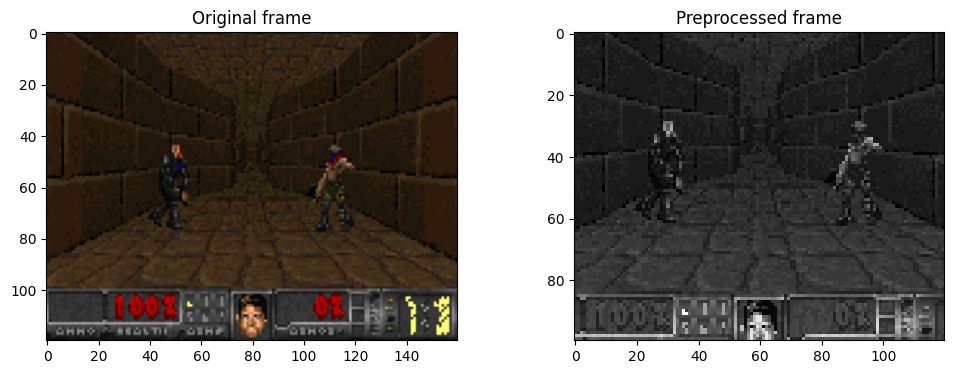

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(frame.transpose(1, 2, 0))
ax[0].set_title("Original frame")
ax[1].imshow(preprocess_frame(frame), cmap="gray")
ax[1].set_title("Preprocessed frame")
plt.show()

In [8]:
class FrameStack:
    def __init__(self, stack_size, frame_shape):
        self.stack_size = stack_size
        self.frame_shape = frame_shape
        self.reset()

    def reset(self):
        self.frames = deque(
            [
                np.zeros(self.frame_shape, dtype=np.uint8)
                for _ in range(self.stack_size)
            ],
            maxlen=self.stack_size,
        )

    def stack(self, frame, is_new_episode=False):
        if is_new_episode:
            self.reset()
            for _ in range(self.stack_size):
                self.frames.append(frame)
        else:
            self.frames.append(frame)

        return np.stack(self.frames, axis=0)

In [9]:
class DDDQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDDQNetwork, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=state_size[0], out_channels=32, kernel_size=8, stride=4
        )
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=4, stride=2
        )

        # 4x100x120 -> conv1(4x100x120) = 32x24x29 -> conv2(32x24x29) = 64x11x13 -> conv3(64x11x13) = 128x4x5
        flatten_size = 128 * 4 * 5

        self.value_fc1 = nn.Linear(flatten_size, 512)
        self.value_fc2 = nn.Linear(512, 1)

        self.advantage_fc1 = nn.Linear(flatten_size, 512)
        self.advantage_fc2 = nn.Linear(512, action_size)

        self.elu = nn.ELU()

    def forward(self, x):
        x = self.elu(self.conv1(x))
        x = self.elu(self.conv2(x))
        x = self.elu(self.conv3(x))
        x = x.view(x.size(0), -1)

        value = self.elu(self.value_fc1(x))
        value = self.value_fc2(value)

        advantage = self.elu(self.advantage_fc1(x))
        advantage = self.advantage_fc2(advantage)

        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)

        return q_values

In [10]:
@dataclass(frozen=True)
class Experience:
    state: np.ndarray
    action: list[int]
    reward: int
    next_state: np.ndarray
    is_episode_finished: bool

In [11]:
class SumTree(object):
    def __init__(self, capacity):
        self.num_leaf_nodes = capacity
        self.priority_tree = np.zeros(2 * capacity - 1)
        self.experiences = np.zeros(capacity, dtype=Experience)
        self.experience_pointer = 0

    def add(self, experience: Experience, priority: float):
        leaf_node_index = self.experience_pointer + self.num_leaf_nodes - 1
        self.experiences[self.experience_pointer] = experience
        self.update(leaf_node_index, priority)
        self.experience_pointer += 1

        if self.experience_pointer >= self.num_leaf_nodes:
            self.experience_pointer = 0

    def update(self, new_node_index, priority):
        change = priority - self.priority_tree[new_node_index]
        self.priority_tree[new_node_index] = priority

        parent_node_index = new_node_index
        while parent_node_index != 0:
            parent_node_index = (parent_node_index - 1) // 2
            self.priority_tree[parent_node_index] += change

    def get_leaf(self, priority):
        parent_index = 0

        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            if left_child_index >= len(self.priority_tree):
                leaf_index = parent_index
                break
            else:
                if priority <= self.priority_tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    priority -= self.priority_tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.num_leaf_nodes + 1

        return leaf_index, self.priority_tree[leaf_index], self.experiences[data_index]

    @property
    def total_priority(self):
        return self.priority_tree[0]

    @property
    def is_full(self):
        return np.all(self.priority_tree[-self.num_leaf_nodes :] != 0)

In [12]:
class ExperienceBuffer:
    def __init__(self, experience_buffer: SumTree, frame_stack: FrameStack):
        self.alpha = 0.6
        self.beta = 0.4
        self.epsilon = 0.01
        self.beta_increment_per_sampling = 0.001
        self.absolute_error_upper = 1

        self.experience_buffer = experience_buffer
        self.frame_stack = frame_stack

    def add(self, experience: Experience):
        max_priority = np.max(
            self.experience_buffer.priority_tree[
                -self.experience_buffer.num_leaf_nodes :
            ]
        )

        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.experience_buffer.add(experience, max_priority)

    def sample(self, batch_size):
        experiences = []
        indices = np.empty(batch_size, dtype=int)
        importance_sampling_weights = np.empty(batch_size, dtype=float)

        priority_segment = self.experience_buffer.total_priority / batch_size
        min_priority = (
            np.min(
                self.experience_buffer.priority_tree[
                    -self.experience_buffer.num_leaf_nodes :
                ]
            )
            / self.experience_buffer.total_priority
        )
        max_weight = (min_priority * batch_size) ** (-self.beta)

        for i in range(batch_size):
            a = priority_segment * i
            b = priority_segment * (i + 1)
            priority = np.random.uniform(a, b)
            leaf_index, priority, experience = self.experience_buffer.get_leaf(priority)
            sampling_probabilities = priority / self.experience_buffer.total_priority
            importance_sampling_weights[i] = (batch_size * sampling_probabilities) ** (
                -self.beta
            ) / max_weight
            indices[i] = leaf_index
            experiences.append(experience)

        self.beta = np.min([1.0, self.beta + self.beta_increment_per_sampling])

        return experiences, indices, importance_sampling_weights

    def batch_update(self, errors, tree_indices):
        errors = np.minimum(errors + self.epsilon, self.absolute_error_upper)
        priorities = errors**self.alpha

        for tree_index, priority in zip(tree_indices, priorities):
            self.experience_buffer.update(tree_index, priority)

    def initialize_experience_buffer(self):
        game, possible_actions = create_environment(set_window_visible=False)
        pbar = tqdm(total=MEMORY_SIZE, desc="Initializing experience buffer")
        while not self.experience_buffer.is_full:
            game.new_episode()
            frame = game.get_state().screen_buffer
            state = self.frame_stack.stack(preprocess_frame(frame), is_new_episode=True)

            while not game.is_episode_finished() and not self.experience_buffer.is_full:
                action = random.choice(possible_actions)
                reward = game.make_action(action)
                is_episode_finished = game.is_episode_finished()

                if is_episode_finished:
                    next_frame = np.zeros(frame.shape, dtype=np.uint8)
                else:
                    next_frame = game.get_state().screen_buffer

                next_state = self.frame_stack.stack(preprocess_frame(next_frame))

                experience = Experience(
                    state, action, reward, next_state, is_episode_finished
                )
                self.add(experience)
                state = next_state
                pbar.update(1)
        pbar.close()
        game.close()

In [13]:
def predict_action(model: nn.Module, state, episode, possible_actions):
    exploration_probability = EXPLORATION_RATE_MIN + (
        EXPLORATION_RATE_MAX - EXPLORATION_RATE_MIN
    ) * np.exp(-EXPLORATION_RATE_DECAY * episode)

    if np.random.rand() < exploration_probability:
        return random.choice(possible_actions)
    else:
        model.eval()
        with torch.no_grad():
            return possible_actions[
                model(
                    torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                )
                .argmax(dim=1)
                .item()
            ]

In [14]:
def train(
    model: nn.Module,
    target_model: nn.Module,
    optimizer: optim.Optimizer,
    experience_buffer: ExperienceBuffer,
    frame_stack: FrameStack,
):
    game, possible_actions = create_environment()
    rewards = []
    step = 0
    for episode in range(TOTAL_EPISODES):
        game.new_episode()
        state = frame_stack.stack(
            preprocess_frame(game.get_state().screen_buffer), is_new_episode=True
        )
        episode_rewards = 0
        for _ in range(MAX_STEPS):
            # Enviorment interaction phase
            action = predict_action(model, state, episode, possible_actions)
            reward = game.make_action(action)
            episode_rewards += reward
            is_episode_finished = game.is_episode_finished()

            if is_episode_finished:
                next_state = np.zeros(state.shape)
            else:
                next_state = frame_stack.stack(
                    preprocess_frame(game.get_state().screen_buffer)
                )

            experience_buffer.add(
                Experience(state, action, reward, next_state, is_episode_finished)
            )
            state = next_state

            # Model training phase
            batch, indices, importance_sampling_weights = experience_buffer.sample(
                BATCH_SIZE
            )
            states_batch = torch.tensor(
                np.array([exp.state for exp in batch]),
                dtype=torch.float32,
                device=device,
            )
            actions_batch = torch.tensor(
                np.array([exp.action for exp in batch]),
                dtype=torch.int64,
                device=device,
            )
            rewards_batch = torch.tensor(
                np.array([exp.reward for exp in batch]),
                dtype=torch.float32,
                device=device,
            )
            next_states_batch = torch.tensor(
                np.array([exp.next_state for exp in batch]),
                dtype=torch.float32,
                device=device,
            )
            is_episode_finished_batch = torch.tensor(
                np.array([exp.is_episode_finished for exp in batch]),
                dtype=torch.bool,
                device=device,
            )

            model.eval()
            with torch.no_grad():
                next_q_values = (
                    target_model(next_states_batch)
                    .gather(1, model(next_states_batch).argmax(dim=1).unsqueeze(1))
                    .squeeze(1)
                )
                target_q_values = (
                    rewards_batch
                    + DISCOUNT_RATE * next_q_values * ~is_episode_finished_batch
                )

            model.train()
            optimizer.zero_grad()
            predicted_q_values = (
                model(states_batch)
                .gather(1, actions_batch.argmax(dim=1).unsqueeze(1))
                .squeeze(1)
            )
            losses = F.mse_loss(predicted_q_values, target_q_values, reduction="none")
            loss = torch.mean(
                losses
                * torch.from_numpy(importance_sampling_weights).float().to(device)
            )
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                absolute_errors = (
                    torch.abs(predicted_q_values - target_q_values).cpu().numpy()
                )
                experience_buffer.batch_update(absolute_errors, indices)

            if (step + 1) % TARGENT_NETWORK_UPDATE_FREQUENCY == 0:
                print("Updating target network")
                target_model.load_state_dict(model.state_dict())

            step += 1

            if is_episode_finished:
                break

        print(
            f"Episode: {episode + 1}, Total reward: {episode_rewards}, Loss: {loss.item()}, Exploration rate: {EXPLORATION_RATE_MIN + (EXPLORATION_RATE_MAX - EXPLORATION_RATE_MIN) * np.exp(-EXPLORATION_RATE_DECAY * episode)}"
        )

        rewards.append(episode_rewards)

    game.close()
    return rewards

In [15]:
model = DDDQNetwork(STATE_SHAPE, ACTION_SIZE).to(device)
target_model = DDDQNetwork(STATE_SHAPE, ACTION_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
experience_buffer = ExperienceBuffer(
    SumTree(MEMORY_SIZE), FrameStack(FRAME_STACK_SIZE, STATE_SHAPE[1:])
)
experience_buffer.initialize_experience_buffer()
frame_stack = FrameStack(FRAME_STACK_SIZE, STATE_SHAPE[1:])

Initializing experience buffer:   0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
rewards = train(model, target_model, optimizer, experience_buffer, frame_stack)

Episode: 1, Total reward: -96.18482971191406, Loss: 21.523181915283203, Exploration rate: 1.0
Episode: 2, Total reward: -109.38140869140625, Loss: 0.4389426112174988, Exploration rate: 0.9998020197986801
Episode: 3, Total reward: 10.051651000976562, Loss: 0.4153136909008026, Exploration rate: 0.999604079189441
Episode: 4, Total reward: -115.99935913085938, Loss: 1.0063666105270386, Exploration rate: 0.9994061781643654
Episode: 5, Total reward: -14.05767822265625, Loss: 1.139277458190918, Exploration rate: 0.9992083167155369
Episode: 6, Total reward: -75.24447631835938, Loss: 21.66812515258789, Exploration rate: 0.9990104948350412
Episode: 7, Total reward: -88.8404541015625, Loss: 0.6956777572631836, Exploration rate: 0.9988127125149655
Episode: 8, Total reward: -103.40432739257812, Loss: 4.630967140197754, Exploration rate: 0.9986149697473984
Episode: 9, Total reward: -106.78033447265625, Loss: 11.983536720275879, Exploration rate: 0.9984172665244303
Episode: 10, Total reward: -99.5526

In [17]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
import time

frame_stack = FrameStack(FRAME_STACK_SIZE, STATE_SHAPE[1:])
game, possible_actions = create_environment(set_window_visible=True)
game.new_episode()
frame = preprocess_frame(game.get_state().screen_buffer)
state = frame_stack.stack(frame, is_new_episode=True)
while True:
    model.eval()
    with torch.no_grad():
        action = possible_actions[
            model(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0))
            .argmax(dim=1)
            .item()
        ]
    game.make_action(action)
    if game.is_episode_finished():
        break
    frame = preprocess_frame(game.get_state().screen_buffer)
    state = frame_stack.stack(frame)
    time.sleep(0.1)
game.close()